In [1]:
import glob
import tarfile
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
def read_logs(folder,files):
    
    def process_tar_archive(tar_file_name):
        """Read logs from tar archive and assign timestamp to each row by doing file name conversion."""
        with tarfile.open(tar_file_name,'r') as tar:
            tar_log_files = tar.getnames()
            queue_log_subset = pd.concat([ pd.read_csv(tar.extractfile(log),delim_whitespace=True).assign(
                Date=datetime.datetime.strptime(log.split('.')[0],'%Y-%m-%d-%H-%M-%S')
                ) for log in tar_log_files ])
        return queue_log_subset
    
    # Obtain archive file names.
    
    tar_files = glob.glob(folder+files)
    tar_files.sort() # Not mandatory.
    
    # Read logs and assign timestamp to each row by doing file name conversion.
    
    queue_logs = pd.concat([ process_tar_archive(tar_file) for tar_file in tar_files ], sort=False)
    
    # Tidy up data frame.
    
    mask = queue_logs['ExecutionHost'].str.contains('--')
    queue_logs = queue_logs[~mask]
    
    # Index data by timestamp. (For plotting.)
    
    queue_logs = queue_logs.set_index('Date')

    return queue_logs


In [3]:
def plot_series(mask):

    # Calculate meta information. (Without consistency checks.)
    
    total_host_number = queue_logs[mask]['ExecutionHost'].unique().size
    base_cpu_number = (queue_logs[mask]['Free_CPUs'].astype('int') + queue_logs[mask]['Used_CPUs'].astype('int')).max()
    base_memory_size = (queue_logs[mask]['Free_Mem1'].astype('int') + queue_logs[mask]['Used_Mem1'].astype('int')).max()
    
    # Define conversions for secondary axis object.
    
    def abs2rel_cpu(absolute_number):
        return (100*absolute_number/base_cpu_number)/total_host_number
    def rel2abs_cpu(relative_number):
        return (relative_number/100*base_cpu_number)*total_host_number
    def abs2rel_mem(absolute_number):
        return (100*absolute_number/base_memory_size*2**8)/total_host_number
    def rel2abs_mem(relative_number):
        return (relative_number/100*base_memory_size/2**8)*total_host_number

    # Plot CPU stuff.
    
    plt.figure()
    ax = (100*queue_logs[mask]['Free_CPUs'].astype('int').resample('3h').mean()/base_cpu_number).plot()
    #(100*queue_logs[mask]['Free_CPUs'].astype('int').resample('1h').quantile(0.9)/base_cpu_number).plot(style=['--'],color=['tab:blue'])
    #(100*queue_logs[mask]['Free_CPUs'].astype('int').resample('1h').quantile(0.1)/base_cpu_number).plot(style=['--'],color=['tab:blue'])
    plt.ylabel('idle CPUs in %\n'+str(total_host_number)+' execution host average')
    plt.title(this_queue+': '+str(base_cpu_number)+' CPUs per execution host')
    # https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/secondary_axis.html
    secaxy = ax.secondary_yaxis('right',functions=(rel2abs_cpu,abs2rel_cpu))
    secaxy.set_ylabel('total number of idle CPUs\nfor '+this_queue+' batch class')
    plt.grid()
    
    # Note that memory units given by the qstat command are not documented.
    # Using a scaling factor of 2**8 yields values that roughly correspond to /proc/meminfo on the execution hosts.
    # For inspiration see e.g. https://en.wikipedia.org/wiki/Orders_of_magnitude_(data)

    # Plot memory stuff.
    
    plt.figure()
    ax = (100*queue_logs[mask]['Free_Mem1'].astype('int').resample('3h').mean()/base_memory_size).plot()
    #(100*queue_logs[mask]['Free_Mem1'].astype('int').resample('1h').quantile(0.9)/base_memory_size).plot(style=['--'],color=['tab:blue'])
    #(100*queue_logs[mask]['Free_Mem1'].astype('int').resample('1h').quantile(0.1)/base_memory_size).plot(style=['--'],color=['tab:blue'])
    plt.ylabel('free memory in %\n'+str(total_host_number)+' execution host average')
    plt.title(this_queue+': '+str(base_memory_size/2**8)+' GB per execution host')
    # https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/secondary_axis.html
    secaxy = ax.secondary_yaxis('right',functions=(rel2abs_mem,abs2rel_mem))
    secaxy.set_ylabel('total free memory in GB\nfor '+this_queue+' batch class')
    plt.grid()
    

In [4]:
queue_logs = read_logs('host_logs/','*.tar.gz')

In [5]:
queue_logs

,Free_CPUs,Free_Mem1,Used_CPUs,Cpu,Used_Mem1,ExecutionHost,QueueName,Free_Swap1,Used_Swap1,Load
Date,,,,,,,,,,
2020-01-12 18:17:31,0,89447,32,32.0,8527,neshcl218,clbigmem,NaN,NaN,NaN
2020-01-12 18:17:31,0,77338,32,32.0,20636,neshcl219,clbigmem,NaN,NaN,NaN
2020-01-12 18:17:31,0,86110,32,31.5,11864,neshcl220,clbigmem,NaN,NaN,NaN
2020-01-12 18:17:31,0,96897,32,32.0,1077,neshcl221,clbigmem,NaN,NaN,NaN
2020-01-12 18:17:31,0,77188,32,32.0,20786,neshcl222,clbigmem,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-04-07 09:53:57,47,1770,1,0.0,47041,neshve03,"bmtest,veexpress,vequeue,veinteractive",935,88,16.0
2020-04-07 09:53:57,47,2086,1,0.0,46725,neshve04,"bmtest,veexpress,vequeue,veinteractive",944,79,16.1
2020-04-07 09:53:57,47,2185,1,0.0,46626,neshve05,"bmtest,veexpress,vequeue,veinteractive",857,166,16.0


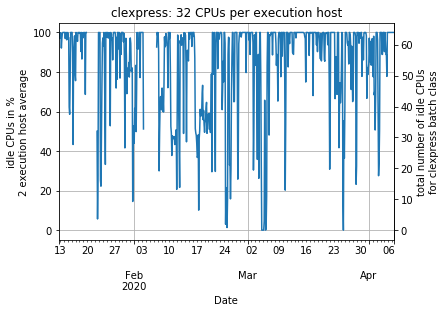

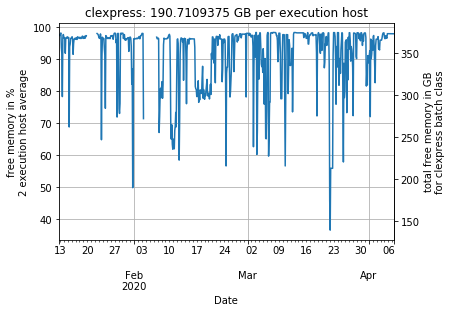

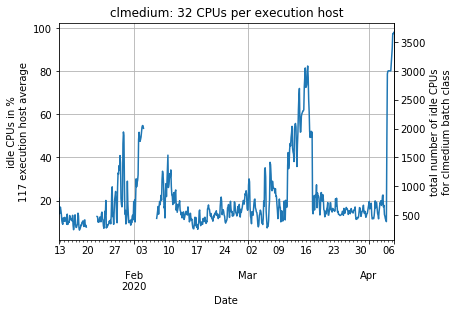

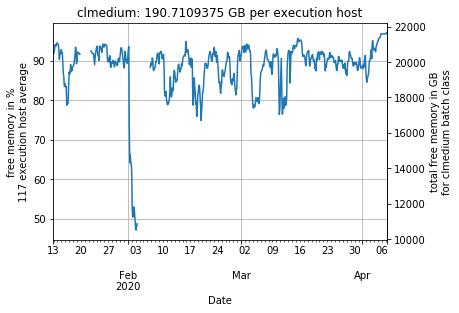

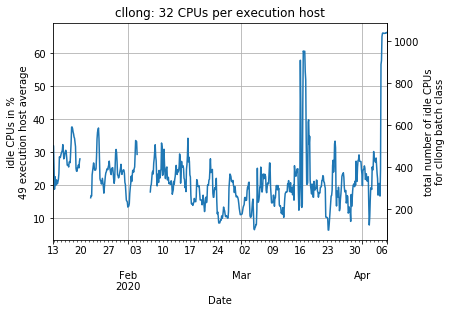

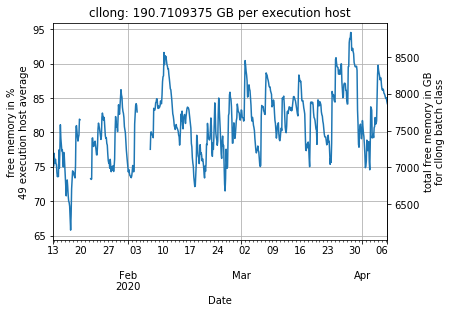

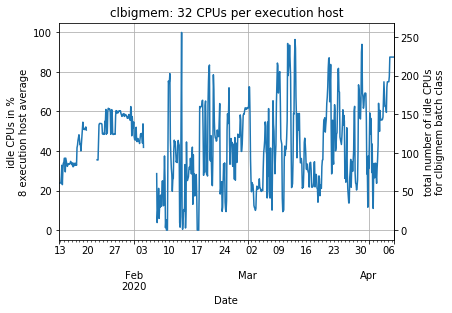

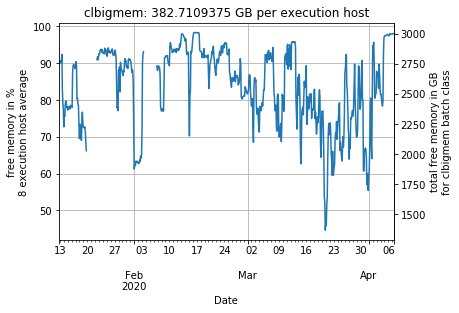

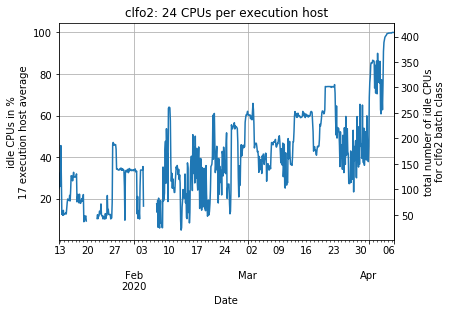

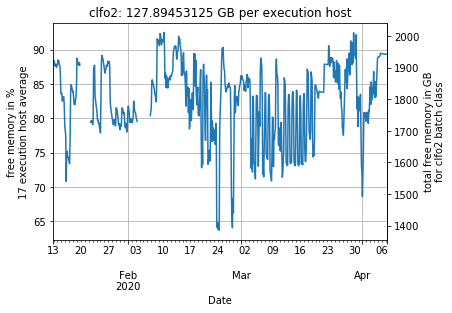

In [6]:
for this_queue in ['clexpress', 'clmedium', 'cllong', 'clbigmem', 'clfo2']:
    mask = queue_logs['QueueName'].str.contains(this_queue, na=False)
    plot_series(mask)

In [7]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
@EXPLICIT
https://conda.anaconda.org/conda-forge/linux-64/_libgcc_mutex-0.1-main.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ca-certificates-2019.11.28-hecc5488_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ld_impl_linux-64-2.33.1-h53a641e_7.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgfortran-ng-7.3.0-hdf63c60_2.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libstdcxx-ng-9.2.0-hdf63c60_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgcc-ng-9.2.0-hdf63c60_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/bzip2-1.0.8-h516909a_2.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/expat-2.2.5-he1b5a44_1004.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/icu-64.2-he1b5a44_1.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/jpeg-9c-h14c3975_1001.tar.bz2
https://conda.anaconda.org/c